## Description

Typical office material supply company running their operations sees many challenges, one of the major ones being how to measure the effectiveness of sales and marketing operations. We have picked up an imaginary office material supply company **“Office Corp.”** for our analysis. They have tested a telemarketing campaign targeting existing domestic business customers with a random selection of products. For this exercise, a sample of 16,172 customers were targeted. The products being marketed are Desk, Executive Chair, Standard Chair, Monitor, Printer Computer, Insurance, Toner and Office Supplies.  

Office Corp would like to leverage the knowledge gained from this survey (and associated dataset) for future campaigns. Office Corp has hired an analyst team to solve the following three problems using various analytical techniques.  

- Profile the customers that responded to the campaign to understand the characteristics of customers who made purchases. 

- Develop models using the campaign results to target responsive, profitable customers for future campaigns. 

- Summarize and categorize the profitability of the various marketing segments which may be used to optimize future campaigns.

---

## Scientific questions/investigation

Given marketing dataset, there are three key problems to solve.  

- Given campaign period data, looking at customer profile, we aim to predict whether customer will Buy or Not Buy. We intent to frame this as a Classification problem. 

- Among the customers who are predicted as they will buy, we aim to estimate what will be size of purchase. We intent to frame this as a Regression problem. 

- For those customers who are likely to purchase and in general other customers using their historical product purchase data, we aim to predict top 3 products that are likely to be purchased. Also try to predict whether there are any product bundles Office Corp may sell more, etc. We intend to frame this as a Clustering problem.  

In the process of analysis, we intent to carry out,  

- data missing and imputation treatments,  

- data sufficiency and randomized splitting for test-train sets,  

- test amount of data necessary for optimal predictions & accuracy, etc.  

This last topic of determining optimal amount of data is called the ‘sample complexity study’ and it is extremely important for such real-life marketing campaign problems because collecting too much data unnecessarily may cause the company cost overrun. Data scientists should be able to advise the business department on how much data to collect to achieve a decent model performance. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [2]:
supply = pd.read_csv("office_supply.csv")

In [3]:
supply = supply[['Customer Number', 'Service Level',' Date of Last Transaction ','Number of Transactions','Email Available']]
supply.columns = ['Customer Number', 'Service Level','Date of Last Transaction','Number of Transactions','Email Available']

In [4]:
campaign = pd.read_excel("office_supply campaign_results.xlsx", 
                         sheet_name="Campaign Results",
                         na_values=[' ',''], true_values=['TRUE'],false_values=['FALSE'])

### Columns

In [5]:
campaign.columns

Index(['Customer Number', 'Campaign Period Sales', 'Historical Sales Volume',
       'Date of First Purchase', 'Number of Prior Year Transactions',
       'Do Not Direct Mail Solicit', 'Do Not Email', 'Do Not Telemarket',
       'Repurchase Method', 'Last Transaction Channel', 'Desk',
       'Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Computer',
       'Insurance', 'Toner', 'Office Supplies', 'Number of Employees',
       'Language'],
      dtype='object')

In [6]:
for c1 in supply.columns:
    if c1 not in campaign.columns:
        print(c1)

Service Level
Date of Last Transaction
Number of Transactions
Email Available


### Join

In [7]:
supply['Customer Number'] = supply['Customer Number'].apply(lambda x: int(x))

In [8]:
campaign=campaign.dropna(axis=0,subset=['Customer Number'])

In [9]:
campaign['Customer Number'] = campaign['Customer Number'].apply(lambda x: int(x))

In [10]:
df = campaign.merge(supply,on='Customer Number')

In [11]:
df.head()

,Customer Number,Campaign Period Sales,Historical Sales Volume,Date of First Purchase,Number of Prior Year Transactions,Do Not Direct Mail Solicit,Do Not Email,Do Not Telemarket,Repurchase Method,Last Transaction Channel,...,Computer,Insurance,Toner,Office Supplies,Number of Employees,Language,Service Level,Date of Last Transaction,Number of Transactions,Email Available
0,86734,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,...,N,Y,N,Y,6-10,English,Premier,2/5/2015,15,True
1,97098,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,...,N,N,N,Y,11-50,English,Premier,10/2/2014,22,True
2,100836,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,...,N,N,N,Y,6-10,English,Premier,3/17/2010,19,True
3,116390,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,...,N,N,N,Y,1-5,English,Standard,8/14/2014,17,True
4,127914,1370.166667,27403.333333,1987-07-15,21.0,0.0,0.0,0.0,NOTICE,BRANCH (PHONE),...,N,Y,N,N,NaN,NaN,Premier,8/17/2015,1,True


In [12]:
df['Date of Last Transaction'] = pd.to_datetime(df['Date of Last Transaction'])

In [13]:
df['Number of Prior Year Transactions'] = df['Number of Prior Year Transactions'].apply(lambda x: int(x))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16190 entries, 0 to 16189
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Customer Number                    16190 non-null  int64         
 1   Campaign Period Sales              16190 non-null  float64       
 2   Historical Sales Volume            16190 non-null  float64       
 3   Date of First Purchase             16190 non-null  datetime64[ns]
 4   Number of Prior Year Transactions  16190 non-null  int64         
 5   Do Not Direct Mail Solicit         16190 non-null  float64       
 6   Do Not Email                       16190 non-null  float64       
 7   Do Not Telemarket                  16190 non-null  float64       
 8   Repurchase Method                  16190 non-null  object        
 9   Last Transaction Channel           15747 non-null  object        
 10  Desk                              

### Fill `Language` missing values by `Unknown` 

In [15]:
df['Language'].fillna('Unknown',inplace=True)

### Dropping all other missing values

In [16]:
df = df.dropna()

In [17]:
df.columns

Index(['Customer Number', 'Campaign Period Sales', 'Historical Sales Volume',
       'Date of First Purchase', 'Number of Prior Year Transactions',
       'Do Not Direct Mail Solicit', 'Do Not Email', 'Do Not Telemarket',
       'Repurchase Method', 'Last Transaction Channel', 'Desk',
       'Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Computer',
       'Insurance', 'Toner', 'Office Supplies', 'Number of Employees',
       'Language', 'Service Level', 'Date of Last Transaction',
       'Number of Transactions', 'Email Available'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12132 entries, 0 to 14965
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Customer Number                    12132 non-null  int64         
 1   Campaign Period Sales              12132 non-null  float64       
 2   Historical Sales Volume            12132 non-null  float64       
 3   Date of First Purchase             12132 non-null  datetime64[ns]
 4   Number of Prior Year Transactions  12132 non-null  int64         
 5   Do Not Direct Mail Solicit         12132 non-null  float64       
 6   Do Not Email                       12132 non-null  float64       
 7   Do Not Telemarket                  12132 non-null  float64       
 8   Repurchase Method                  12132 non-null  object        
 9   Last Transaction Channel           12132 non-null  object        
 10  Desk                              

### Categorical variables

In [19]:
cat_vars = ['Do Not Direct Mail Solicit', 'Do Not Email', 'Do Not Telemarket',
       'Repurchase Method', 'Last Transaction Channel', 'Desk',
       'Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Computer',
       'Insurance', 'Toner', 'Office Supplies', 'Number of Employees', 'Language','Service Level','Email Available']

In [20]:
len(cat_vars)

18

### What are the unique values in the columns?

In [21]:
for v in cat_vars:
    print(f"Values in {v}: {df[v].unique()}")

Values in Do Not Direct Mail Solicit: [0. 1.]
Values in Do Not Email: [0. 1.]
Values in Do Not Telemarket: [0. 1.]
Values in Repurchase Method: ['AUTO RENEW' 'NOTICE']
Values in Last Transaction Channel: ['AUTO RENEW' 'MAIL' 'PHONE' 'WEB' 'BRANCH (POS)' 'BRANCH (PHONE)' 'IT'
 'BILLING']
Values in Desk: ['N' 'Y']
Values in Executive Chair: ['N' 'Y']
Values in Standard Chair: ['N' 'Y']
Values in Monitor: ['N' 'Y']
Values in Printer: ['N' 'Y']
Values in Computer: ['N' 'Y' 'YY']
Values in Insurance: ['Y' 'N']
Values in Toner: ['N' 'Y']
Values in Office Supplies: ['Y' 'N']
Values in Number of Employees: ['6-10' '11-50' '1-5' '51-100' '101-500' '500+']
Values in Language: ['English' 'Unknown' 'Hindi' 'Italian' 'French' 'Chinese' 'Portuguese'
 'Russian' 'Spanish' 'Hebrew' 'Japanese' 'German' 'Polish' 'Arabic'
 'Greek' 'Vietnamese' 'Korean' 'Thai' 'Pashto']
Values in Service Level: ['Premier' 'Standard']
Values in Email Available: [ True False]


### Converting boolean columns to proper data types

In [22]:
#type_dict = {}


In [23]:
df=df.astype({'Do Not Direct Mail Solicit': 'bool', 'Do Not Email':bool, 'Do Not Telemarket':bool})

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12132 entries, 0 to 14965
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Customer Number                    12132 non-null  int64         
 1   Campaign Period Sales              12132 non-null  float64       
 2   Historical Sales Volume            12132 non-null  float64       
 3   Date of First Purchase             12132 non-null  datetime64[ns]
 4   Number of Prior Year Transactions  12132 non-null  int64         
 5   Do Not Direct Mail Solicit         12132 non-null  bool          
 6   Do Not Email                       12132 non-null  bool          
 7   Do Not Telemarket                  12132 non-null  bool          
 8   Repurchase Method                  12132 non-null  object        
 9   Last Transaction Channel           12132 non-null  object        
 10  Desk                              

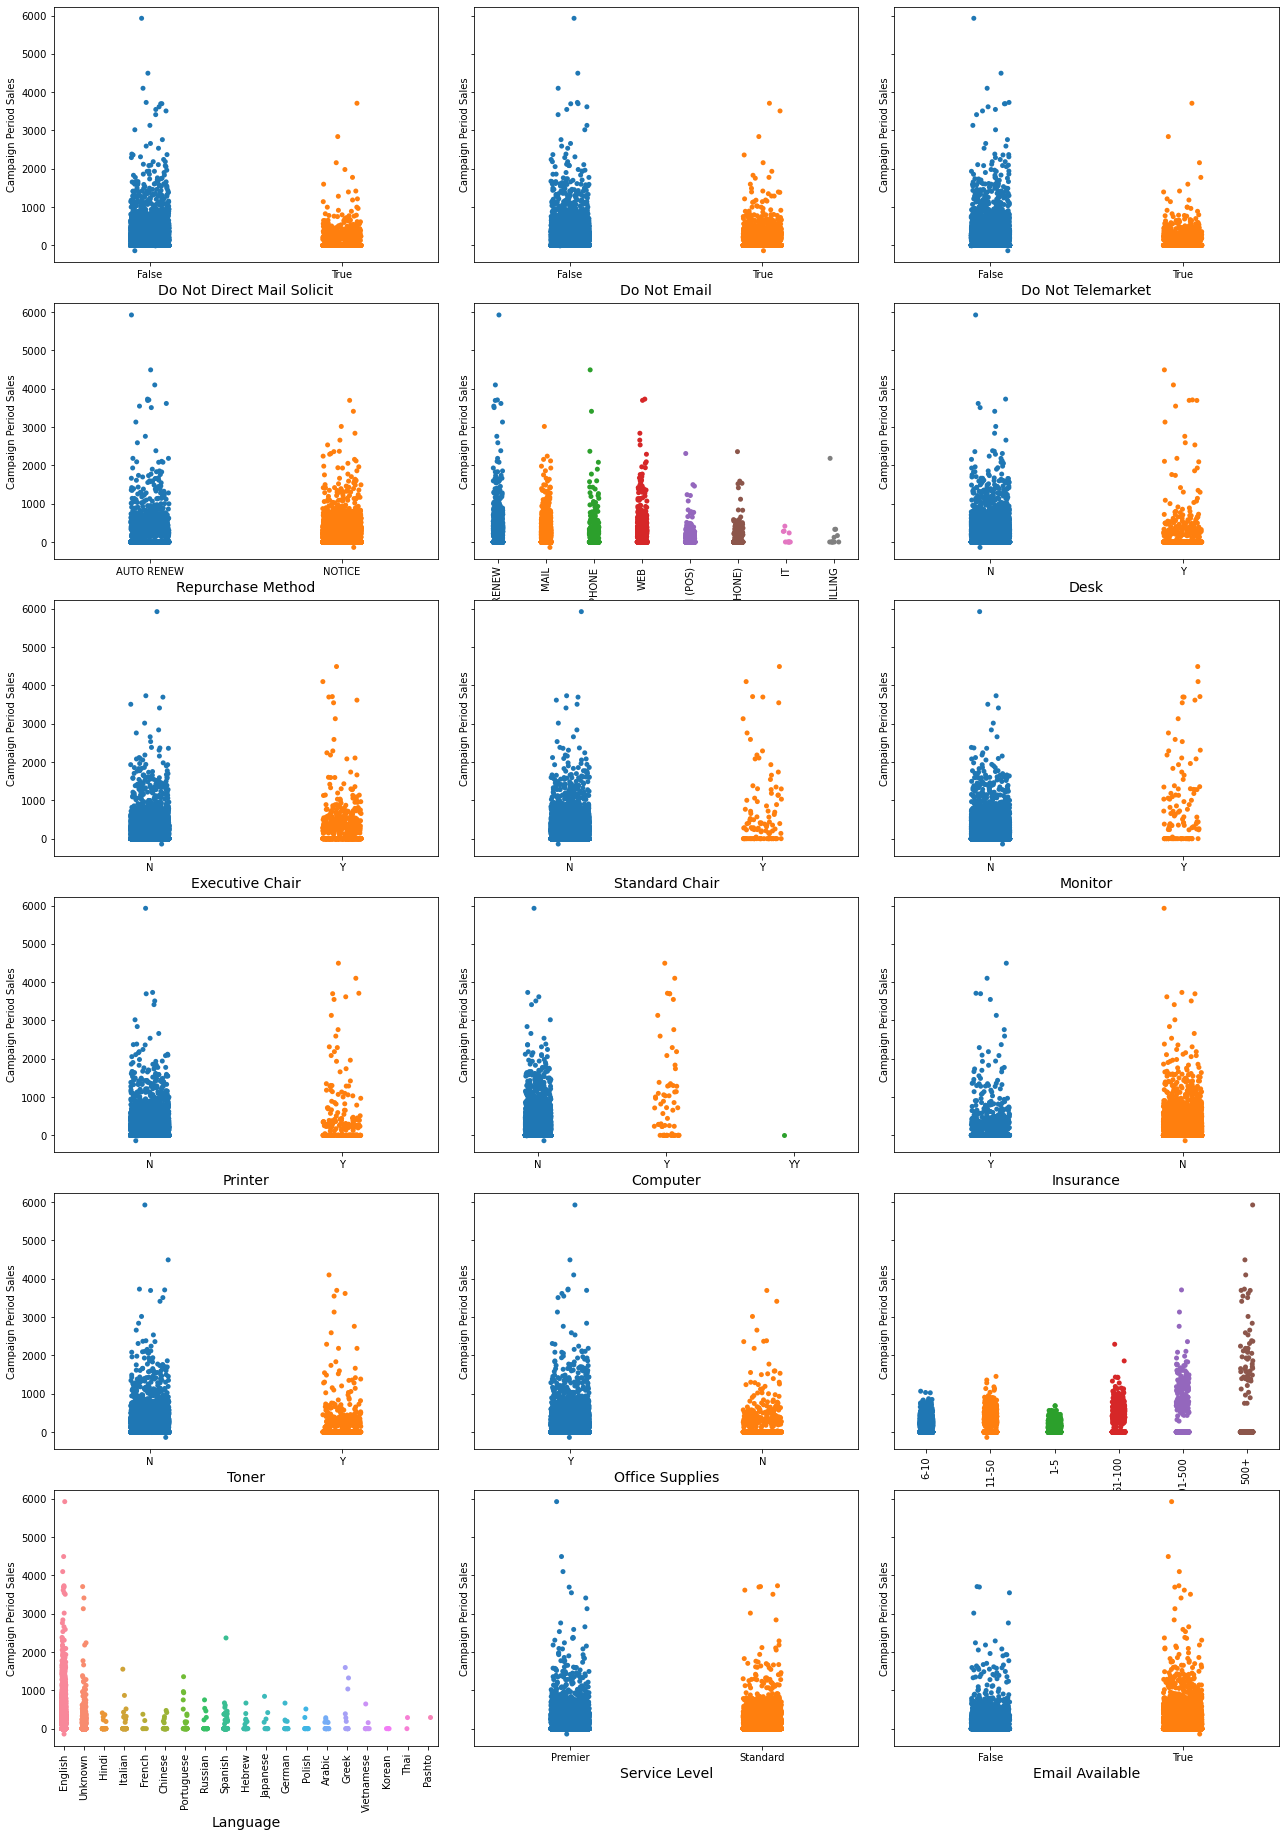

In [25]:
fig, ax = plt.subplots(6,3,figsize=(18,25),squeeze=False,sharey=True)
fig.tight_layout(pad=2.0)
ax = ax.ravel()
for i in range(18):
    sns.stripplot(x=cat_vars[i],y='Campaign Period Sales',data=df,ax=ax[i],edgecolor='k')
    ax[i].set_xlabel(cat_vars[i],fontsize=14)
    if len(df[cat_vars[i]].unique()) > 3:
        ax[i].set_xticklabels(labels=df[cat_vars[i]].unique(), rotation = 90)
plt.show()

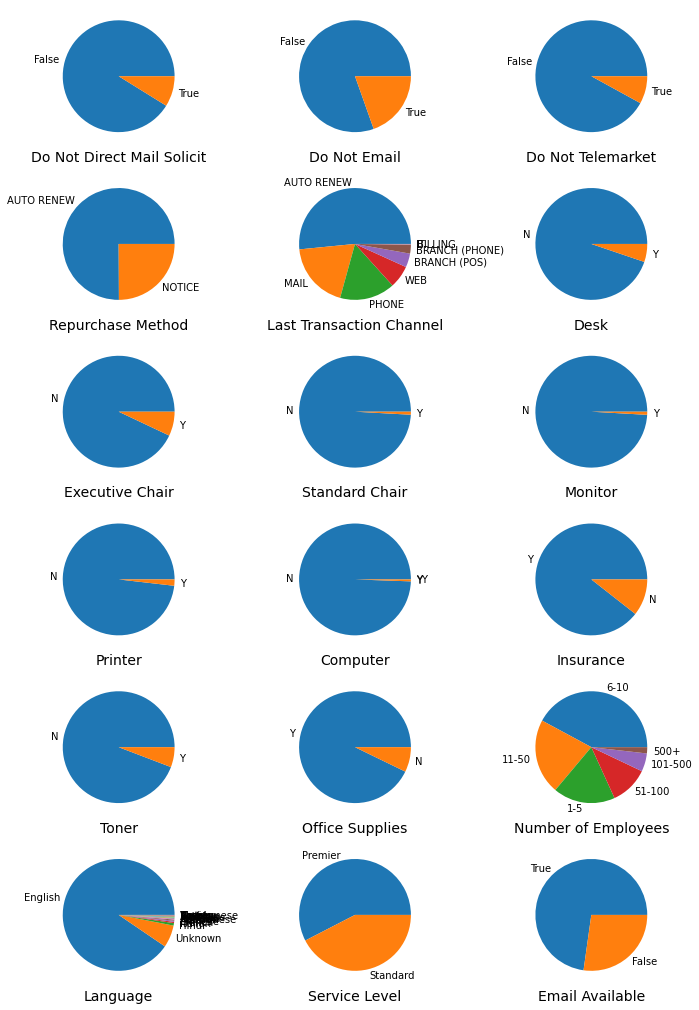

In [26]:
fig, ax = plt.subplots(6,3,figsize=(12,18),squeeze=True,sharey=True)
ax = ax.ravel()
for i in range(18):
    ax[i].pie(df[cat_vars[i]].value_counts(),
        labels=df[cat_vars[i]].unique())
    ax[i].set_xlabel(cat_vars[i],fontsize=14)
plt.show()

### Buy/No buy?

In [27]:
df['Buy'] = (df['Campaign Period Sales'] > 0).apply(lambda x: int(x))

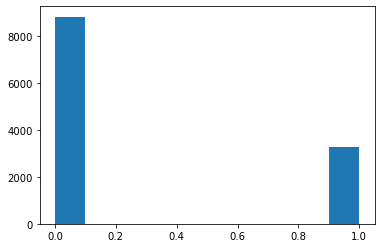

In [28]:
plt.hist(df['Buy'])
plt.show()

### Customer engagement length (days)

In [29]:
df['Customer_engagement_days'] = (pd.Timestamp.now().normalize() - df['Date of First Purchase']).dt.days

In [30]:
df['Days_since_last_transaction'] = (pd.Timestamp.now().normalize() - df['Date of Last Transaction']).dt.days

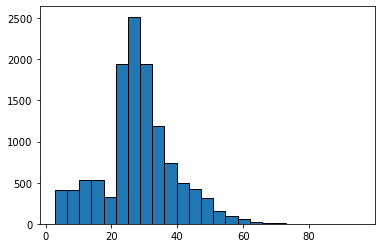

In [31]:
plt.hist(df['Customer_engagement_days']/365,bins=25,edgecolor='k')
plt.show()

In [32]:
df['Date of First Purchase'].describe()

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   12132
unique                   2876
top       1997-07-01 00:00:00
freq                      117
first     1926-01-15 00:00:00
last      2018-05-29 00:00:00
Name: Date of First Purchase, dtype: object

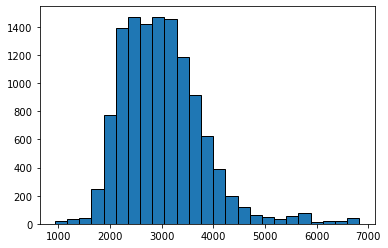

In [33]:
plt.hist(df['Days_since_last_transaction'],bins=25,edgecolor='k')
plt.show()

In [34]:
def customer_engagement(d):
    m = df['Customer_engagement_days'].mean()
    s = df['Customer_engagement_days'].std()
    if d >= m+s:
        return 'Long-term'
    elif d > m-s and d < m+s:
        return 'Mid-term'
    else:
        return 'Short-term'

In [35]:
m = df['Customer_engagement_days'].mean()
s = df['Customer_engagement_days'].std()

print(m/365,s/365)

28.212618050756745 10.874667067643749


In [36]:
df['Customer_engagement_length'] = df['Customer_engagement_days'].apply(customer_engagement)

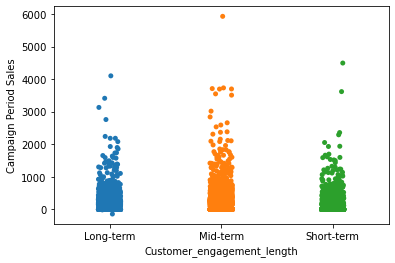

In [37]:
sns.stripplot(x='Customer_engagement_length',y='Campaign Period Sales',data=df)
plt.show()

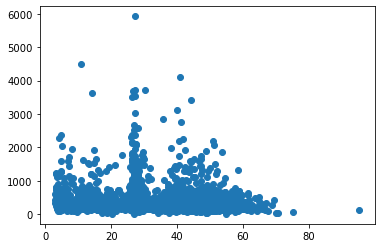

In [38]:
df2 = df[df['Buy']==1]
plt.scatter(df2['Customer_engagement_days']/365,df2['Campaign Period Sales'])
plt.show()

### Language grouping

In [39]:
df['Language'].unique()

array(['English', 'Unknown', 'Hindi', 'Italian', 'French', 'Chinese',
       'Portuguese', 'Russian', 'Spanish', 'Hebrew', 'Japanese', 'German',
       'Polish', 'Arabic', 'Greek', 'Vietnamese', 'Korean', 'Thai',
       'Pashto'], dtype=object)

In [40]:
def language_group(lan):
    if lan=='English':
        return 'English'
    elif lan=='Hindi' or lan=='Chinese' or lan=='Hebrew' or lan=='Japanese' or lan=='Arabic' or lan=='Vietnamese' or lan=='Thai' or lan=='Pashto':
        return 'Asian'
    elif lan=='Unknown':
        return 'Unknown'
    else:
        return 'European'        

In [41]:
df['Language_group'] = df['Language'].apply(language_group)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12132 entries, 0 to 14965
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Customer Number                    12132 non-null  int64         
 1   Campaign Period Sales              12132 non-null  float64       
 2   Historical Sales Volume            12132 non-null  float64       
 3   Date of First Purchase             12132 non-null  datetime64[ns]
 4   Number of Prior Year Transactions  12132 non-null  int64         
 5   Do Not Direct Mail Solicit         12132 non-null  bool          
 6   Do Not Email                       12132 non-null  bool          
 7   Do Not Telemarket                  12132 non-null  bool          
 8   Repurchase Method                  12132 non-null  object        
 9   Last Transaction Channel           12132 non-null  object        
 10  Desk                              

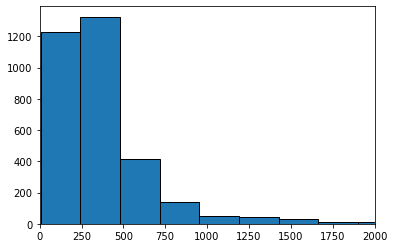

In [43]:
plt.hist(df[df['Buy']==1]['Campaign Period Sales'],bins=25,edgecolor='k')
plt.xlim(0,2000)
plt.show()

### Saving to a CSV

In [44]:
df.to_csv('Cleaned_campaign_sale.csv')

In [45]:
d=pd.get_dummies(df,columns=cat_vars)

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12132 entries, 0 to 14965
Data columns (total 76 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Customer Number                          12132 non-null  int64         
 1   Campaign Period Sales                    12132 non-null  float64       
 2   Historical Sales Volume                  12132 non-null  float64       
 3   Date of First Purchase                   12132 non-null  datetime64[ns]
 4   Number of Prior Year Transactions        12132 non-null  int64         
 5   Date of Last Transaction                 12132 non-null  datetime64[ns]
 6   Number of Transactions                   12132 non-null  int64         
 7   Buy                                      12132 non-null  int64         
 8   Customer_engagement_days                 12132 non-null  int64         
 9   Days_since_last_transaction            

In [48]:
d.head()

,Customer Number,Campaign Period Sales,Historical Sales Volume,Date of First Purchase,Number of Prior Year Transactions,Date of Last Transaction,Number of Transactions,Buy,Customer_engagement_days,Days_since_last_transaction,...,Language_Portuguese,Language_Russian,Language_Spanish,Language_Thai,Language_Unknown,Language_Vietnamese,Service Level_Premier,Service Level_Standard,Email Available_False,Email Available_True
0,86734,238.704762,146803.428571,1968-10-01,15,2015-02-05,15,1,19170,2242,...,0,0,0,0,0,0,1,0,0,1
1,97098,281.680000,439984.160000,1981-06-15,22,2014-10-02,22,1,14530,2368,...,0,0,0,0,0,0,1,0,0,1
2,100836,432.857143,970465.714286,1962-11-01,19,2010-03-17,19,1,21331,4028,...,0,0,0,0,0,0,1,0,0,1
3,116390,0.000000,230193.600000,1983-06-01,17,2014-08-14,17,0,13814,2417,...,0,0,0,0,0,0,0,1,0,1
5,148529,308.419048,182584.076190,1979-05-15,16,2012-08-24,16,1,15292,3137,...,0,0,0,0,0,0,1,0,1,0


In [49]:
len(d[d['Campaign Period Sales']==0.0])

8843

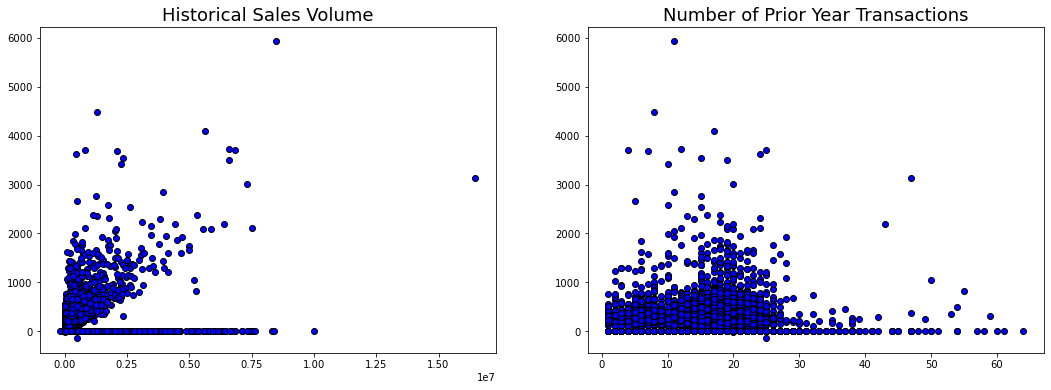

In [50]:
fig,ax=plt.subplots(1,2,figsize=(18,6))
ax[0].scatter(d['Historical Sales Volume'],d['Campaign Period Sales'],c='blue',edgecolor='k')
ax[0].set_title('Historical Sales Volume',fontsize=18)
ax[1].scatter(d['Number of Prior Year Transactions'],d['Campaign Period Sales'],c='blue',edgecolor='k')
ax[1].set_title('Number of Prior Year Transactions',fontsize=18)
plt.show()